# COMP41680: Data Science in Python

# ASSIGNMENT 2 

# Student Number : 19200123

In [1]:
#Importing all the necessary packages
import urllib3
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
import numpy as np
from nltk.corpus import stopwords
stop_list = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from tokenize import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline


# TASK 1

## Creating a function to scrape all the data from a website in a html format

In [2]:
def scrape_data(url):
    url = url
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser") #Using beautifulSOup to scrape all the data
    return soup

#### Initializing the website link and sending it to the scrape_data function

In [3]:
main_page_url = "http://mlg.ucd.ie/modules/yalp/"
main_page_data = scrape_data(main_page_url)
main_page_data #Contains the website data in a HTML format

<!DOCTYPE html>

<html lang="en">
<head>
<meta content="noindex" name="robots"/>
<meta content="Content on this site is posted for teaching purposes only. Original data is from yelp.com" name="description"/>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<title>Yalp Home</title>
<link href="images/favicon.ico" rel="shortcut icon"/>
<!-- Bootstrap core CSS -->
<link href="assets/css/bootstrap.css" rel="stylesheet"/>
<!-- Custom styles for this template -->
<link href="assets/css/style.css" rel="stylesheet"/>
<link href="assets/css/font-awesome.min.css" rel="stylesheet"/>
<script src="assets/js/modernizr.js"></script>
</head>
<body>
<div class="container mtb">
<div class="row">
<div class="col-md-12">
<h3 class="info"><a class="info" href="index.html">Yalp</a> — Home</h3>
</div>
</div>
<div class="row">
<div class="col-md-10" id="content">
<div id="all">
<p>Select a business category fro

### Creating a function to extract all the anchor tags and append all the links to an arry

In [4]:
def page_links(page):
    links = [] #initializing a blank list to store all the anchor tags 
    for link in page.find_all('a'): #using find_all to get all the anchor tags
        links.append(link.get('href')) #using .get to get the links for the corresponding anchor tag and appending it to the list
    return links

#### Calling the function on the scrapped data to extract links 

In [5]:
category_page_url = [] #creating a blank list to store all the links
category_page_url = page_links(main_page_data) #calling the page_links function on the main webpage
category_page_url #printing all the extracted links(list of categories)

['index.html',
 'automotive_list.html',
 'cafes_list.html',
 'fashion_list.html',
 'gym_list.html',
 'hair_salons_list.html',
 'hotels_list.html',
 'restaurants_list.html']

#### Selecting 3 categories

In [6]:
category_page_url = category_page_url[1:4]

category_page_url = [main_page_url + s for s in category_page_url] #appending the main page URL to get the complete link for each category
category_page_url #Printing the complete links for the categories 

['http://mlg.ucd.ie/modules/yalp/automotive_list.html',
 'http://mlg.ucd.ie/modules/yalp/cafes_list.html',
 'http://mlg.ucd.ie/modules/yalp/fashion_list.html']

#### Collecting all web data from each categories 

In [7]:
category_page_data = [] #creating a new list to store all the data for each category
for link in category_page_url:
    category_page_data.append(scrape_data(link)) #Using the scrape_data function to scrape data from link for each category link
    

#### Seperating each category web data into their respective variable


In [8]:
automotive_page_data = category_page_data[0]
cafes_page_data = category_page_data[1]
fashion_page_data = category_page_data[2]
automotive_page_data #sample data

<!DOCTYPE html>

<html lang="en">
<head>
<meta content="noindex" name="robots"/>
<meta content="Content on this site is posted for teaching purposes only. Original data is from yelp.com" name="description"/>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<title>Yalp Reviews for Automotive</title>
<link href="images/favicon.ico" rel="shortcut icon"/>
<!-- Bootstrap core CSS -->
<link href="assets/css/bootstrap.css" rel="stylesheet"/>
<!-- Custom styles for this template -->
<link href="assets/css/style.css" rel="stylesheet"/>
<link href="assets/css/font-awesome.min.css" rel="stylesheet"/>
<script src="assets/js/modernizr.js"></script>
</head>
<body>
<div class="container mtb">
<div class="row">
<div class="col-md-12">
<h3 class="info"><a class="info" href="index.html">Yalp</a> — Reviews for Automotive</h3>
</div>
</div>
<div class="row">
<div class="col-md-10" id="content">
<div id="all

## Creating a function to get all the reviews

In [9]:
def get_review_links(page_data):
    col_names = ('reviews','rating') #Creating columnnames for df
    df = pd.DataFrame(columns=col_names) #creating new df with two columns 
    review_data =[]
    image_tags = []
    paragraph_text =[]
    res = []
    review = page_links(page_data) #using page_links function to get all the links for each business 
    review.pop(0) #popping the first link as its index.html
    review = [main_page_url + s for s in review] #appending the main url to get the complete link for each review 
    
    for link in review:
        review_data.append(scrape_data(link)) #using scrape_data to get all the data for each business based using thier corresponding link
        
    for data in review_data: #Iterating over reviews for each business 
        p_tags = data.find_all('p', attrs={'class':'review-text'}) #using find_all to get all the p tags which have the attribute review-text in class as review-text contains the actual reviews
        
        for tag in p_tags:
            paragraph_text.append(tag.get_text()) #for each review, using tag.get_text which only returns the text from a tag which is the actual reviews we need
            
        collection = data.findAll("img") #Finding all the image tags from the page
        
        for img in collection: #iterating over every image tag
            if 'alt' in img.attrs: # checking condition for alt attribute in image tag
                if (img.attrs['alt'] == '4-star' or img.attrs['alt'] == '5-star'):
                    image_tags.append('positive') #assigning positive review for 4 and 5 stars 
                else:
                    image_tags.append('negative') #assigning negative review for 1,2 and 3 stars
    df['reviews'] = paragraph_text #Storing all the review text in the df column
    df['rating'] = image_tags #Storing all the generated review labels in the df column
    return df
    

### Calling the get_review_links for each category of reviews

In [10]:
automotive_review = get_review_links(automotive_page_data)
cafes_review = get_review_links(cafes_page_data)
fashion_review = get_review_links(fashion_page_data)

## Function to pre-process the reviews

In [11]:
def text_preprocess(value):
    value['reviews'] = value['reviews'].str.lower() #lowercase all words
    value['reviews']=value['reviews'].str.split().map(lambda sl: " ".join(s for s in sl if len(s) > 2)) #remove word less than 2 char
    value['reviews'] = value['reviews'].str.replace(r'\d+','') #removing numbers
    value['reviews'] = value['reviews'].str.replace(r'[ ](?=[ ])|[^-_,A-Za-z0-9 ]+', "") #removing special characters 
    value['tokenized_sentences'] = value.apply(lambda row: nltk.word_tokenize(row['reviews']), axis=1) #tokenizing 
    value['tokenized_sentences']= value['tokenized_sentences'].apply(lambda x: [item for item in x if item not in stop_list]) #removing stopwords
    value['tokenized_sentences'] = value['tokenized_sentences'].apply(lambda x : [stemmer.stem(y) for y in x]) #stemming 
    value['tokenized_sentences'] = value['tokenized_sentences'].apply(lambda x : [lemmatizer.lemmatize(y) for y in x]) #lemmatizing 
    value['clean_string'] = value['tokenized_sentences'].str.join(' ') #converting back to normal string from tokenized string 
    return value

### Calling text_preprocess function to clean review text for each category 

In [12]:
automotive_review = text_preprocess(automotive_review)
cafes_review = text_preprocess(cafes_review)
fashion_review = text_preprocess(fashion_review)

# TASK 2 AND TASK 3

### Storing labels for each review in a new array

In [13]:
y_auto = np.array(automotive_review['rating'])
y_cafes = np.array(cafes_review['rating'])
y_fashion = np.array(fashion_review['rating'])
y_fashion #sample data

array(['positive', 'negative', 'positive', ..., 'negative', 'negative',
       'negative'], dtype=object)

## TASK 2a: Converting data to numeric representation (TF-IDF)

In [14]:
v = TfidfVectorizer(max_features=2500) #Initializnig the TF-IDF Vectorizer 

### Finding the TD-IDF for each word and storing it in a new variable as an array

In [15]:
X_auto = v.fit_transform(automotive_review['clean_string']).toarray()
X_cafes = v.fit_transform(cafes_review['clean_string']).toarray()
X_fashion = v.fit_transform(fashion_review['clean_string']).toarray()
X_fashion #sample data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.30945468, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Checking to see if data is imbalanced 

In [16]:
automotive_review['rating'].value_counts()

positive    1212
negative     788
Name: rating, dtype: int64

In [17]:
cafes_review['rating'].value_counts()

positive    1462
negative     538
Name: rating, dtype: int64

In [18]:
fashion_review['rating'].value_counts()

positive    1205
negative     795
Name: rating, dtype: int64

We can see that the dataset is imbalanced as there are many more positive reviews compared to negative ones

### Splitting data for training and testing 

Splitting data for automotive category

In [19]:
X_train_auto, X_test_auto, y_train_auto, y_test_auto = train_test_split(X_auto, y_auto, test_size=0.3, random_state=0)


Splitting data for cafes category

In [20]:
X_train_cafes, X_test_cafes, y_train_cafes, y_test_cafes = train_test_split(X_cafes, y_cafes, test_size=0.3, random_state=0)

Splitting data for fashion category

In [21]:
X_train_fashion, X_test_fashion, y_train_fashion, y_test_fashion = train_test_split(X_fashion, y_fashion, test_size=0.3, random_state=0)

### Creating print_evaulator function which prints the evaluation measures to test the classifier

In [22]:
def print_evaluators(test,pred):
    print(confusion_matrix(test,pred)) #using confusion_matrix function to print the confusion matrix
    print(classification_report(test,pred)) #Using classification_report function to get the summary of how good the classifier is 
    print(accuracy_score(test, pred)) #Using accuracy_score function to get the overall accuracy
    array = confusion_matrix(test,pred)
    df_cm = pd.DataFrame(array, range(2), range(2))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}) # font size

    plt.show()

# <font color='red'> TRAINING ON AUTOMOTIVE CATEGORY AND EVALUATING </font>
---
#### Using RandomForest Classifier

Initializing Random Forest Classifier for training classifier using automotive reviews 

In [23]:
classifier_auto = RandomForestClassifier(n_estimators=1000, random_state=0) #Initializing classifier

In [24]:
classifier_auto.fit(X_train_auto, y_train_auto)  #Training classifier with automotive reviews

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## Evaluating Automotive Classifier with Automotive test data

In [25]:
y_pred_auto = classifier_auto.predict(X_test_auto) 

[[190  53]
 [ 18 339]]
              precision    recall  f1-score   support

    negative       0.91      0.78      0.84       243
    positive       0.86      0.95      0.91       357

    accuracy                           0.88       600
   macro avg       0.89      0.87      0.87       600
weighted avg       0.88      0.88      0.88       600

0.8816666666666667


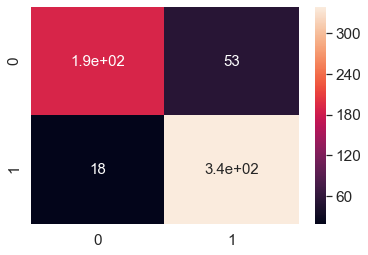

In [26]:
print_evaluators(y_test_auto,y_pred_auto) #printing evaluation measures 

### Evaluation measures considered 
#### Accuracy: Which is the ratio of number of correct predictions by the total number of predictions 
#### Precision: Which is the number of true positives divided by the sum of true positives and false positives 
#### Recall: Which is the number of true positives divided by the sum of true positives and false negatives
#### F1 score: Which is the harmonic mean of Precision and Recall
---

### Interpreting Results
We get an overall accuracy of 88% when we test it with the automotive reviews itself

If we check the confusion matrix we get the corresponding values 

TP = 339 which means 339 reviews were predicted positive and were actually positive

TN = 190 which means 190 reviews were predicted negative and were actually negative

FP = 18 which means 18 reviews were predicted positive but were actually negative

FN = 53 which means 53 reviews were predicted negative but were actually positive

We also calculate the average F1 score for the classifier as only accuracy is not a good measure because the dataset is imbalanced as mentioned above

We get the average F1 score as 0.88

So overall the classifer worked well on automotive data

## Evaluating Automotive Classifier with Cafes test data

In [27]:
y_pred_auto_cafes = classifier_auto.predict(X_test_cafes)

[[ 35 103]
 [ 76 386]]
              precision    recall  f1-score   support

    negative       0.32      0.25      0.28       138
    positive       0.79      0.84      0.81       462

    accuracy                           0.70       600
   macro avg       0.55      0.54      0.55       600
weighted avg       0.68      0.70      0.69       600

0.7016666666666667


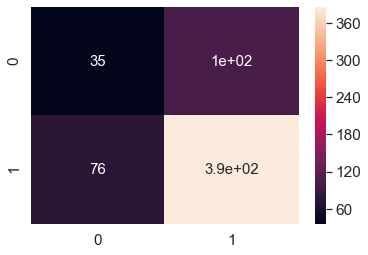

In [28]:
print_evaluators(y_test_cafes,y_pred_auto_cafes)#printing evaluation measures 

### Interpreting Results
We get an overall accuracy of 70% when we test it with the cafes reviews 

If we check the confusion matrix we get the corresponding values

TP = 386 which means 386 reviews were predicted positive and were actually positive

TN = 35 which means 35 reviews were predicted negative and were actually negative

FP = 76 which means 76 reviews were predicted positive but were actually negative

FN = 103 which means 103 reviews were predicted negative but were actually positive

Average F1 score = 0.69

Overall there were many wrong predictions by the classifier on the cafes dataset, but still, the classifer worked well

## Evaluating Automotive Classifier with Fashion test data

In [29]:
y_pred_auto_fashion = classifier_auto.predict(X_test_fashion)

[[ 45 198]
 [ 47 310]]
              precision    recall  f1-score   support

    negative       0.49      0.19      0.27       243
    positive       0.61      0.87      0.72       357

    accuracy                           0.59       600
   macro avg       0.55      0.53      0.49       600
weighted avg       0.56      0.59      0.54       600

0.5916666666666667


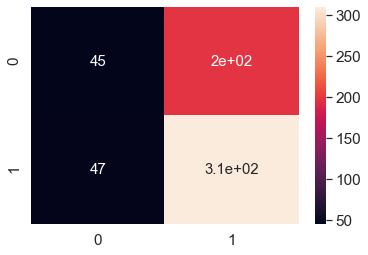

In [30]:
print_evaluators(y_test_fashion,y_pred_auto_fashion) #printing evaluation measures 

### Interpreting Results
We get an overall accuracy of 59% when we test it with the fashion reviews

If we check the confusion matrix we get the corresponding values

TP = 310 which means 310 reviews were predicted positive and were actually positive

TN = 45 which means 45 reviews were predicted negative and were actually negative

FP = 47 which means 47 reviews were predicted positive but were actually negative

FN = 198 which means 198 reviews were predicted negative but were actually positive

We get the average F1 score as 0.54

For the fashion dataset we had a large number of False Negatives and a very low F1 score, hence the classifer performed poorly for this dataset

# <font color='red'> TRAINING ON CAFES CATEGORY AND EVALUATING </font>
---

Initializing Random Forest Classifier for training classifier using cafes reviews

In [31]:
classifier_cafes = RandomForestClassifier(n_estimators=1000, random_state=0) #Initializing classifier 

In [32]:
classifier_cafes.fit(X_train_cafes, y_train_cafes) #Training classifier with cafes review

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## Evaluating Cafes Classifier with Cafes test data

In [33]:
y_pred_cafes = classifier_cafes.predict(X_test_cafes)

[[ 62  76]
 [ 10 452]]
              precision    recall  f1-score   support

    negative       0.86      0.45      0.59       138
    positive       0.86      0.98      0.91       462

    accuracy                           0.86       600
   macro avg       0.86      0.71      0.75       600
weighted avg       0.86      0.86      0.84       600

0.8566666666666667


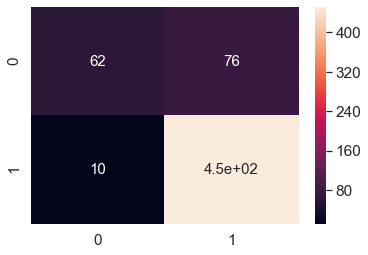

In [34]:
print_evaluators(y_test_cafes,y_pred_cafes) #printing evaluation measures 

### Interpreting Results
We get an overall accuracy of 85% when we test it with the cafes reviews itself

If we check the confusion matrix we get the corresponding values

TP = 452 which means 452 reviews were predicted positive and were actually positive

TN = 62 which means 62 reviews were predicted negative and were actually negative

FP = 10 which means 10 reviews were predicted positive but were actually negative

FN = 76 which means 76 reviews were predicted negative but were actually positive

Average F1 score = 0.84

We get a high accuracy and F1 score, hence the classifier worked well on this data as expected

## Evaluating Cafes Classifier with automotive test data

In [35]:
y_pred_cafes_auto = classifier_cafes.predict(X_test_auto)

[[ 12 231]
 [ 14 343]]
              precision    recall  f1-score   support

    negative       0.46      0.05      0.09       243
    positive       0.60      0.96      0.74       357

    accuracy                           0.59       600
   macro avg       0.53      0.51      0.41       600
weighted avg       0.54      0.59      0.47       600

0.5916666666666667


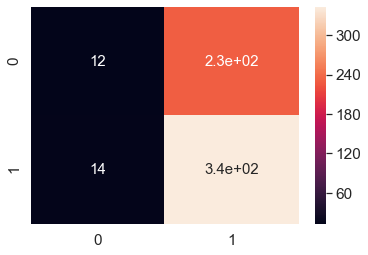

In [36]:
print_evaluators(y_test_auto,y_pred_cafes_auto) #printing evaluation measures 


### Interpreting results 
We get an overall accuracy of 59% when we test it with the automotive reviews 

If we check the confusion matrix we get the corresponding values

TP = 343 which means 343 reviews were predicted positive and were actually positive

TN = 12 which means 12 reviews were predicted negative and were actually negative

FP = 14 which means 14 reviews were predicted positive but were actually negative

FN = 231 which means 231 reviews were predicted negative but were actually positive

Average F1 score = 0.47

We can see that there is a large number of False Negatives and hence we get a very low F1 score, Overall the classifer performed very poorly on this dataset

## Evaluating Cafes Classifier with Fashion test data

In [37]:
y_pred_cafes_fashion = classifier_cafes.predict(X_test_fashion)

[[  6 237]
 [ 12 345]]
              precision    recall  f1-score   support

    negative       0.33      0.02      0.05       243
    positive       0.59      0.97      0.73       357

    accuracy                           0.58       600
   macro avg       0.46      0.50      0.39       600
weighted avg       0.49      0.58      0.46       600

0.585


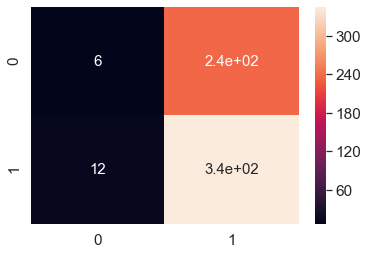

In [38]:
print_evaluators(y_test_fashion,y_pred_cafes_fashion) #printing evaluation measures 

### Interpreting Results 
We get an overall accuracy of 58% when we test it with the fashion reviews 

If we check the confusion matrix we get the corresponding values

TP = 345 which means 345 reviews were predicted positive and were actually positive

TN = 6 which means 6 reviews were predicted negative and were actually negative

FP = 12 which means 12 reviews were predicted positive but were actually negative

FN = 237 which means 237 reviews were predicted negative but were actually positive

Average F1 score = 0.46

Again there was a large number of False Negatives and therefore it resulted in a low F1 score and hence the classifiers performance was bad on this dataset too

# <font color='red'> TRAINING ON FASHION CATEGORY AND EVALUATING </font>
---

In [39]:
classifier_fashion = RandomForestClassifier(n_estimators=1000, random_state=0) #Initializing classifier

In [40]:
classifier_fashion.fit(X_train_fashion, y_train_fashion) #Training classifier with fashion data

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## Evaluating Fashion Classifier with Fashion test data

In [41]:
y_pred_fashion = classifier_fashion.predict(X_test_fashion)

[[182  61]
 [ 13 344]]
              precision    recall  f1-score   support

    negative       0.93      0.75      0.83       243
    positive       0.85      0.96      0.90       357

    accuracy                           0.88       600
   macro avg       0.89      0.86      0.87       600
weighted avg       0.88      0.88      0.87       600

0.8766666666666667


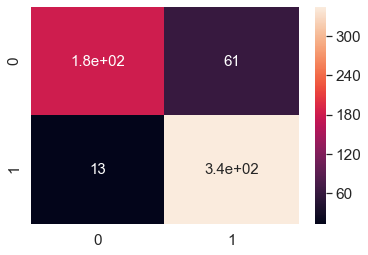

In [42]:
print_evaluators(y_test_fashion,y_pred_fashion) #printing evaluation measures 

### Interpreting Results 
We get an overall accuracy of 87.6% when we test it with the fashion reviews itself

If we check the confusion matrix we get the corresponding values

TP = 344 which means 344 reviews were predicted positive and were actually positive

TN = 182 which means 182 reviews were predicted negative and were actually negative

FP = 13 which means 13 reviews were predicted positive but were actually negative

FN = 61 which means 61 reviews were predicted negative but were actually positive

Average F1 score = 0.87

Overall the classifier worked very well and had a high accuracy and F1 score

## Evaluating Fashion Classifier with Automotive test data

In [43]:
y_pred_fashion_auto = classifier_fashion.predict(X_test_auto)

[[ 21 222]
 [ 42 315]]
              precision    recall  f1-score   support

    negative       0.33      0.09      0.14       243
    positive       0.59      0.88      0.70       357

    accuracy                           0.56       600
   macro avg       0.46      0.48      0.42       600
weighted avg       0.48      0.56      0.47       600

0.56


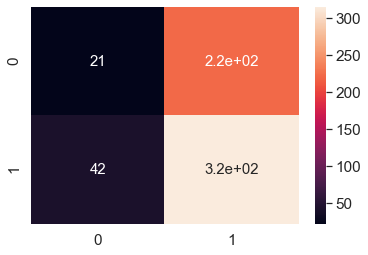

In [44]:
print_evaluators(y_test_auto,y_pred_fashion_auto) #printing evaluation measures 

### Interpreting Results 
We get an overall accuracy of 56% when we test it with the automotive data which is very poor

If we check the confusion matrix we get the corresponding values

TP = 315 which means 315 reviews were predicted positive and were actually positive

TN = 21 which means 21 reviews were predicted negative and were actually negative

FP = 42 which means 42 reviews were predicted positive but were actually negative

FN = 222 which means 222 reviews were predicted negative but were actually positive

Average F1 score = 0.47

We get a very high number of False Negatives and a very low F1 Score and Overall the classifier worked very poorly on this dataset

## Evaluating Fashion Classifier with Cafes test data

In [45]:
y_pred_fashion_cafes = classifier_fashion.predict(X_test_cafes)

[[ 21 117]
 [ 54 408]]
              precision    recall  f1-score   support

    negative       0.28      0.15      0.20       138
    positive       0.78      0.88      0.83       462

    accuracy                           0.71       600
   macro avg       0.53      0.52      0.51       600
weighted avg       0.66      0.71      0.68       600

0.715


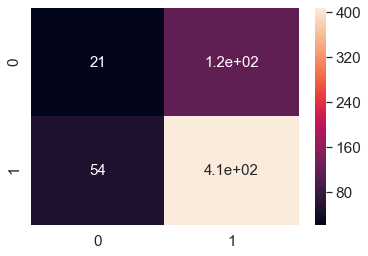

In [46]:
print_evaluators(y_test_cafes,y_pred_fashion_cafes) #printing evaluation measures 

### Interpreting Results 
We get an overall accuracy of 71.5% when we test it with the cafes reviews

If we check the confusion matrix we get the corresponding values

TP = 408 which means 408 reviews were predicted positive and were actually positive

TN = 21 which means 21 reviews were predicted negative and were actually negative

FP =54 which means 54 reviews were predicted positive but were actually negative

FN = 117 which means 117 reviews were predicted negative but were actually positive

Average F1 score = 0.68

Overall the classifier worked well even though this classifier was tested on a different dataset but the F1 score was a bit poor.